# Before You Start

The current set of notebooks are under constant development.

## Update Tutorial Repository

If you have previously cloned the tutorial repository, you may need to get the latest versions of the notebooks.

First check the status of your repository:
```
cd hls4ml-tutorial
make clean
git status 
```

You may have some _modified_ notebooks. For example:

```
# On branch csee-e6868-spring2021
# Changes not staged for commit:
#   (use "git add <file>..." to update what will be committed)
#   (use "git checkout -- <file>..." to discard changes in working directory)
#
#	modified:   part1_getting_started.ipynb
#	modified:   part2_advanced_config.ipynb
#	modified:   part2b_advanced_config.ipynb
#
no changes added to commit (use "git add" and/or "git commit -a")
```

You can make a copy of those modified notebooks if you had significat changes, otherwise the easiest thing to do is to discard those changes.

**ATTENTION** You will loose your local changes!

```
git checkout *.ipynb
```

At this point, you can update you copy of the repository:
```
git pull
```


## Update Conda Environment

It is likely that you are running this notebook in the Conda environment `hls4ml-tutorial-cu`.

If you did not do that yet, you should update the `hls4ml` packages with the latest changes in the working branch.

```
conda activate hls4ml-tutorial-cu
pip uninstall hls4ml
pip install git+https://github.com/GiuseppeDiGuglielmo/hls4ml.git@gdg/cosmetics#egg=hls4ml[profiling]
```

You may need to restart the Jupyter notebook.

# Part 2: Advanced Configuration

In this notebook, we will learn more about design-space exploration with hls4ml. We will focus on post-training quantization (introduced in [Part 1](part1_getting_started.ipynb)) and reuse factor.

## Setup

As we did in [Part 1](part1_getting_started.ipynb), let's import the libraries, call the magic functions, and setup the environment variables.

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2018.2/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


### Load the dataset

In [Part 1](part1_getting_started.ipynb), we saved the preprocessed dataset to files. Let's load them.

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

### Load the model

In [Part 1](part1_getting_started.ipynb), we saved the trained model to file. Let's load it as well.

**Make sure you've run through that walkthrough first!**

In [3]:
from tensorflow.keras.models import load_model
model = load_model('model_1/KERAS_check_best_model.h5')
y_keras = model.predict(X_test)

### Create an hls4ml configuration & model

This time, we'll create an hls4ml configuration dictionary with _finer granularity_.

When we used `granularity='model'`, the generated configuration was:
```
-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
-----------------------------------
```

Now instead we are using `granularity='model'` and we print the configuration, you'll notice that an entry is created for each named layer of the model. See for the first layer, for example:
```
-----------------------------------
[...]
LayerName:
  fc1:
      Precision:
          weight: ap_fixed<16,6>
          bias:   ap_fixed<16,6>
          result: ap_fixed<16,6>
      ReuseFactor: 1
[...]
-----------------------------------
```
Taken _out of the box_ this configuration will set all the parameters to the same settings as in [Part 1](part1_getting_started.ipynb), but we can use it as a template to start modifying things. 

In [4]:
import hls4ml
import plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  fc1_input
    Precision
      result:        ap_fixed<16,6>
  fc1
    Precision
      weight:        ap_fixed<16,6>
      bias:          ap_fixed<16,6>
      result:        ap_fixed<16,6>
    ReuseFactor:     1
  fc1_linear
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
  relu1
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
  fc2
    Precision
      weight:        ap_fixed<16,6>
      bias:          ap_fixed<16,6>
      result:        ap_fixed<16,6>
    ReuseFactor:     1
  fc2_linear
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
  relu2
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    ta

In the remaining of the notebook we will investigate how to leverage the `Precision` and `ReuseFactor` knobs to run design-space exploration.

## Design Space Exploration for Post-Training Quantization

### Profile

With this new dictionary, we can choose the precision of _everything_ in our neural network. This is a powerful way to tune the performance, but the _fine tuning_ of all of these parameters is also complicated.

The tools in `hls4ml.model.profiling` can help you choose the right precision for your model. (That said, training your model with quantization built in can get around this problem, and that is introduced in Part 4. So, don't go too far down the rabbit hole of tuning your data types without first trying out quantization aware training with [QKeras](https://github.com/google/qkeras).)

The first thing to try is to numerically profile your model. This method plots the distribution of the weights (and biases) as a [box and whisker plot](https://en.wikipedia.org/wiki/Box_plot#:~:text=In%20descriptive%20statistics%2C%20a%20box,whisker%20plot%20and%20box%2Dand%2D). The grey boxes show the values which can be represented with the data types used in the `hls_model`. Generally,
- you need the box to overlap completely with the whisker *to the right* (large values) otherwise you'll get saturation & wrap-around issues;
- it can be okay for the box not to overlap completely *to the left* (small values), but finding how small you can go is a matter of trial-and-error.

Providing data, in this case just using the first 1000 examples for speed, will show the same distributions captured at the output of each layer.

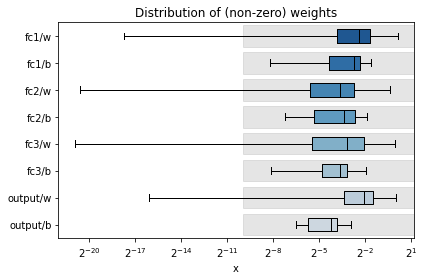

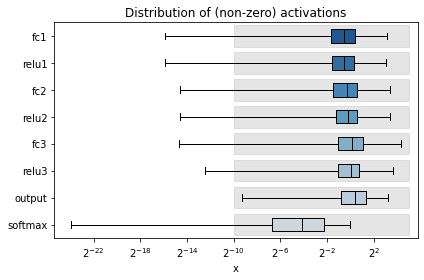

In [5]:
%matplotlib inline
# Create an HLS model from the Keras model and hls4ml configuration dictionary
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj_2',
                                                       #fpga_part='xczu7ev-ffvc1156-2-e') # ZCU106
                                                       fpga_part='xczu3eg-sbva484-1-e') # Ultra96
                                                       #fpga_part='xc7z020clg400-1') # Pynq-Z1
                                                       #fpga_part='xc7z007sclg225-1') # MiniZed
# Run profiling
_ = hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X_test[:1000])

### Customize

Let's just try setting the precision of the first layer in the weights to something more narrow than 16 bits. Using fewer bits can save resources in the FPGA. After inspecting the profiling plot above, let's try 8 bits with 1 integer bit.

Then create a new `hls_model`, and display the profiling with the new config. This time, just display the weight profile by not providing any data '`X`'. Then create the `HLSModel` and display the architecture. Notice the box around the weights of the first layer reflects the different precision.

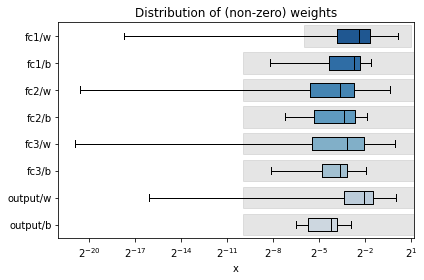

In [6]:
# Fine tune the precision of the weights in the first layer
config['LayerName']['fc1']['Precision']['weight'] = 'ap_fixed<8,2>'

# Create an HLS model from the Keras model and the updated hls4ml configuration dictionary
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj_2',
                                                       #fpga_part='xczu7ev-ffvc1156-2-e') # ZCU106
                                                       fpga_part='xczu3eg-sbva484-1-e') # Ultra96
                                                       #fpga_part='xc7z020clg400-1') # Pynq-Z1
                                                       #fpga_part='xc7z007sclg225-1') # MiniZed
# Run profiling (weights only, no X is provided)
_ = hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)

As we did in [Part 1](part1_getting_started.ipynb), let's visualise the HLS model that we just created.

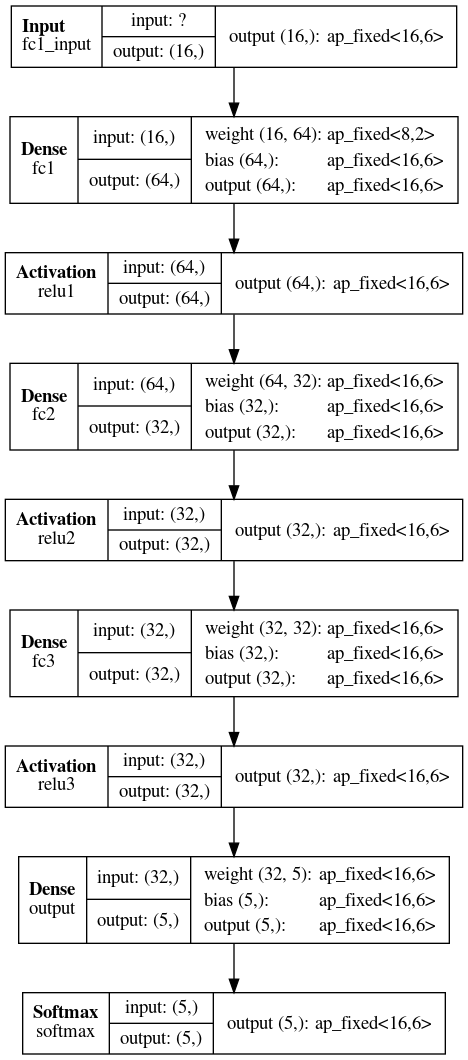

In [7]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

### Enable Tracing
When we start using customised precision throughout the model, it can be useful to collect the output from each layer to find out when things have gone wrong. We enable this trace collection by setting `Trace = True` for each layer whose output we want to collect.

In [8]:
# Enable tracing for all of the layers
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True

# Create an HLS model from the Keras model and the updated hls4ml configuration dictionary
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj_2',
                                                       #fpga_part='xczu7ev-ffvc1156-2-e') # ZCU106
                                                       fpga_part='xczu3eg-sbva484-1-e') # Ultra96
                                                       #fpga_part='xc7z020clg400-1') # Pynq-Z1
                                                       #fpga_part='xc7z007sclg225-1') # MiniZed

### Compile, trace, predict

Now we need to check that this model performance is still good after reducing the precision.

We compile the `hls_model`, and now use the `hls_model.trace` method to collect the model output, and also the output for all the layers we enabled tracing for. The trace is a dictionary with keys corresponding to the layer names of the model; stored at that key is the array of values output by that layer, sampled from the provided data.

A helper function `get_ymodel_keras` returns the same dictionary for the Keras model that is with the floating point precision.

We'll just run the `trace` for the first 1000 examples, since it takes a bit longer and uses more memory than just running `predict`. 

In [9]:
%%time
# Recompile the hls model
hls_model.compile()

# Run tracing on a portion of the test set for the hls model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X_test[:1000]))

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test[:1000])

# Run prediction on all of the test set for the hls model (fixed-point precision)
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

CPU times: user 28.8 s, sys: 0 ns, total: 28.8 s
Wall time: 40.9 s


### Manual Inspection
Now we can print out, make plots, or do any other more detailed analysis on the output of each layer to make sure we haven't made the performance worse. And if we have, we can quickly find out where. Let's just print the output of the first layer, for the first sample, for both the Keras and hls4ml models.

In [10]:
print('-----------------------------------')
print("Keras layer 'fc1', first sample:")
print(keras_trace['fc1'][0])
print('-----------------------------------')
print("hls4ml layer 'fc1', first sample:")
print(hls4ml_trace['fc1'][0])
print('-----------------------------------')

-----------------------------------
Keras layer 'fc1', first sample:
tf.Tensor(
[ 1.3292742  -0.2302183  -2.0366437  -1.2120054   0.7416081   1.3615751
  2.612251    2.1288736   0.21484476 -1.088266    0.05726445 -0.2668879
  1.5091325   0.6220924  -0.70007163  0.7001285   0.23282304  0.4922374
  0.6745743   0.8000517   1.0608277   0.42807603  0.53755635 -1.0823957
 -1.1123356   0.5795952  -0.582136   -2.1491349   0.85669065  0.07045264
  1.8480949   0.63228923  0.12453032  0.7612911   1.3596876   1.3382385
  0.7255056  -2.3511758  -0.4696419  -0.0650042  -0.372414    0.187222
 -1.1873419  -0.79782623  1.5176731  -1.5924486   1.345645    1.925499
 -1.5909086  -1.7679815   0.57388085 -2.1301763  -1.5468764   1.7079327
  1.2805736   0.5532505  -1.1864831  -1.480964    0.8524523   0.9260583
 -1.499645    0.72034115 -1.2616737  -1.0809991 ], shape=(64,), dtype=float32)
-----------------------------------
hls4ml layer 'fc1', first sample:
[ 1.28808594 -0.24804688 -2.05273438 -1.22949219  0.

### Compare
Let's see if we lost performance by using 8 bits for the weights of the first layer by inspecting the accuracy and ROC curve.

-----------------------------------
Keras  Accuracy: 0.7502650602409638
hls4ml Accuracy: 0.7494156626506024
-----------------------------------


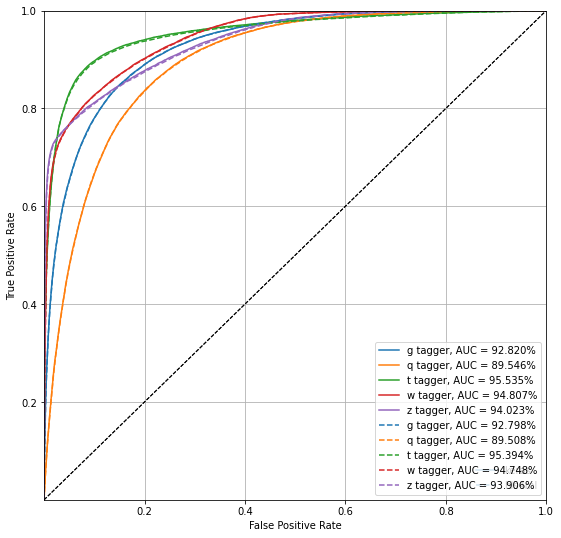

In [11]:
print('-----------------------------------')
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print('-----------------------------------')

# Enable logarithmic scale on TPR and FPR axes 
logscale_tpr = False # Y axis
logscale_fpr = False # X axis

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_hls, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
_ = ax.add_artist(leg)

The AUC results for the Keras and hls4ml implementation are again really close, but you can notice a little more difference with respect the plot in [Part 1](part1_getting_started.ipynb). Apply logaritmic scale on the FPR axis (logscale_fpr=True) to better appreciate differences.

### PTQ Summary
We lost a small amount of accuracy compared to when we used `ap_fixed<16,6>`, but in many cases this difference will be small enough to be worth the resource saving. You can choose how aggressive to go with quantization, but it's always sensible to make the profiling plots even with the default configuration. Layer-level `trace` is very useful for finding when you reduced the bitwidth too far, or when the default configuration is no good for your model.

In this model, _post training quantization_ at around 8-bits width generally seems to be the limit to how low you can go before suffering significant performance loss. In Part 4, we'll look at using _training aware quantization_ with QKeras to go much lower without losing much performance.

## Design Space Exploration for Reuse Factor
Now let's look at the other configuration parameter: `ReuseFactor`.
Recall that `ReuseFactor` is our mechanism for tuning the parallelism:

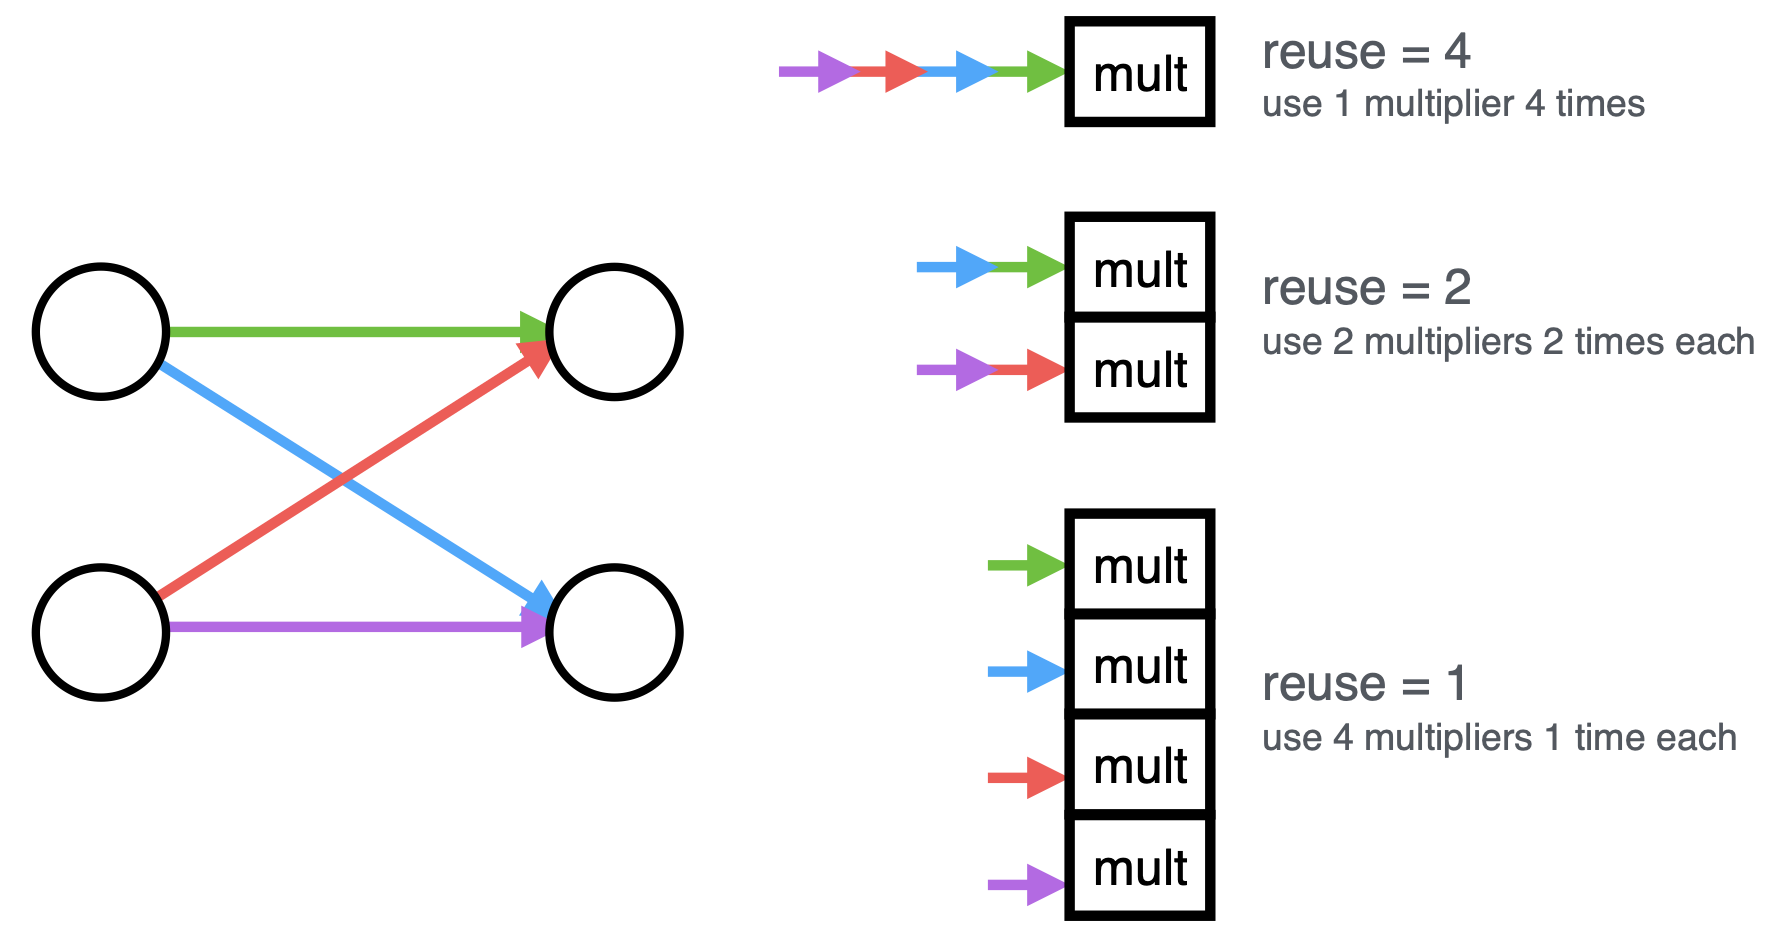

So now let's make a new configuration for this model, and set the `ReuseFactor` to `2` for every layer:
we'll compile the model, then evaulate its performance. (Note, by creating a new config with `granularity=Model`, we're implicitly resetting the precision to `ap_fixed<16,6>` throughout.)

In [12]:
# Generate a hls4ml configuration dictionary from the Keras model
config = hls4ml.utils.config_from_keras_model(model, granularity='Model')

# Set the ReuseFactor to 2 for all of the layers of the model
config['Model']['ReuseFactor'] = 2

print('-----------------------------------')
# Show the generated configuration dictionary for hls4ml
plotting.print_dict(config)
print('-----------------------------------')

# Create an HLS model from the Keras model and the updated hls4ml configuration dictionary
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj_2',
                                                       #fpga_part='xczu7ev-ffvc1156-2-e') # ZCU106
                                                       fpga_part='xczu3eg-sbva484-1-e') # Ultra96
                                                       #fpga_part='xc7z020clg400-1') # Pynq-Z1
                                                       #fpga_part='xc7z007sclg225-1') # MiniZed
_ = hls_model.compile()

-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       2
  Strategy:          Latency
-----------------------------------


Changing the `ReuseFactor` should not change the classification results, but let's just verify that by inspecting the accuracy and ROC curve again!
Then we'll build the model.

-----------------------------------
Keras  Accuracy: 0.7502650602409638
hls4ml Accuracy: 0.7502650602409638
-----------------------------------


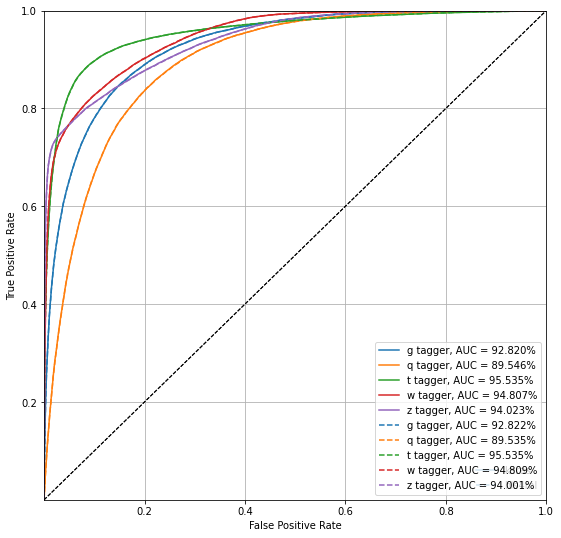

In [13]:
# Run prediction on all of the test set for the hls model (fixed-point precision)
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

print('-----------------------------------')
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print('-----------------------------------')

# Enable logarithmic scale on TPR and FPR axes 
logscale_tpr = False # Y axis
logscale_fpr = False # X axis

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_hls, classes, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
_ = ax.add_artist(leg)

Let's run Vivado HLS to synthesize the model (_C-Synthesis_).

**This takes approx. 15 minutes on Columbia servers.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj_2/vivado_hls.log`

In [14]:
%%time
hls_results = hls_model.build(csim=False)

CPU times: user 45 ms, sys: 38 ms, total: 83 ms
Wall time: 11min 48s


And now print the report, compare this to the report from Exercise 1.

In [15]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj_2')

Found 1 solution(s) in model_1/hls4ml_prj_2/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jan 27 16:23:59 2021

* Version:        2018.2 (Build 2258646 on Thu Jun 14 20:25:20 MDT 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.617|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   18|   18|    2|    2| function |
    +-----+-----+-----+-----+-----

In [16]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jan 27 16:00:05 2021

* Version:        2018.2 (Build 2258646 on Thu Jun 14 20:25:20 MDT 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.198|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   15|   15|    1|    1| function |
    +-----+-----+-----+-----+-------

For the new design, we are expecting half of the DSP usage and _Initiation Interval_ equals to 2.

## Exercise
1. Recall the outcome of the exercise of Part 1 where we estimated how many DSPs our network should use. How does this change now we've used `ReuseFactor = 2` for the network? Does the expectation match the report this time?
2. By leveraging `Precision` and `Reuse Factor`, try to create HLS models that fit at least the ZCU106 and Ultra96 boards.